In [5]:
import os

from dotenv import find_dotenv, load_dotenv

In [6]:
load_dotenv(find_dotenv('.env'))

True

In [7]:
os.environ["LANGCHAIN_PROJECT"] = "RAG From Scratch: Part 1 (Overview)"

![](images/rag.png)

# Part 1: Overview

![](images/01-01-overview.png)

![](images/01-02-overview.png)

## Configure components

In [ ]:
from langchain_openai import OpenAIEmbeddings, OpenAI

ModuleNotFoundError: No module named 'langchain.openai'

In [ ]:
GIGACHAT_API_BASE_URL = os.environ["GIGACHAT_API_BASE_URL"]
GIGACHAT_API_USER = os.environ["GIGACHAT_API_USER"]
GIGACHAT_API_PASSWORD = os.environ["GIGACHAT_API_PASSWORD"]

## Load documents

In [1]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [11]:
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
len(docs)

1

In [ ]:
print(docs[0].page_content[:1000])

## Split documents

In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

ModuleNotFoundError: No module named 'langchain'

In [9]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
len(splits)

NameError: name 'RecursiveCharacterTextSplitter' is not defined

## Store documents

In [10]:
from langchain_core.vectorstores import InMemoryVectorStore

In [ ]:
vectorstore = InMemoryVectorStore(embeddings)
doc_ids = vectorstore.add_documents(documents=splits)
len(doc_ids), len(vectorstore.store)

## RAG

In [ ]:
rag_prompt_template = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:"""
print(rag_prompt_template)

In [ ]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

### LangChain

In [ ]:
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

In [ ]:
rag_prompt = ChatPromptTemplate.from_template(rag_prompt_template)

In [ ]:
retriever = vectorstore.as_retriever()

chain = (
    {
        "context": retriever | format_docs, 
        "question": RunnablePassthrough()
    }
    | rag_prompt
    | llm
    | StrOutputParser()
)

In [ ]:
response = chain.invoke("What is Task Decomposition?")
print(response)

### LangGraph

In [12]:
from typing import TypedDict

from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langgraph.graph import END, START, StateGraph

In [13]:
class State(TypedDict):
    question: str
    context: list[Document]
    answer: str

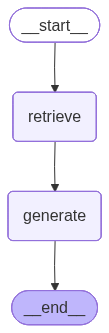

In [14]:
def retrieve(state: State):
    retrieved_docs = vectorstore.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = format_docs(state["context"])
    rag_prompt = rag_prompt_template.format(
        question=state["question"],
        context=docs_content
    )
    response = llm.invoke([
        HumanMessage(content=rag_prompt)
    ])
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("generate", END)
graph = graph_builder.compile()
graph

In [15]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

NameError: name 'vectorstore' is not defined